# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.ensemble import GradientBoostingClassifier
from collections import defaultdict
import seaborn as sns

Будем использовать torchvision для работы с данными.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [3]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


(50000, 10000)

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [4]:
def denormalize_image(image):
    return (image + 1) / 2

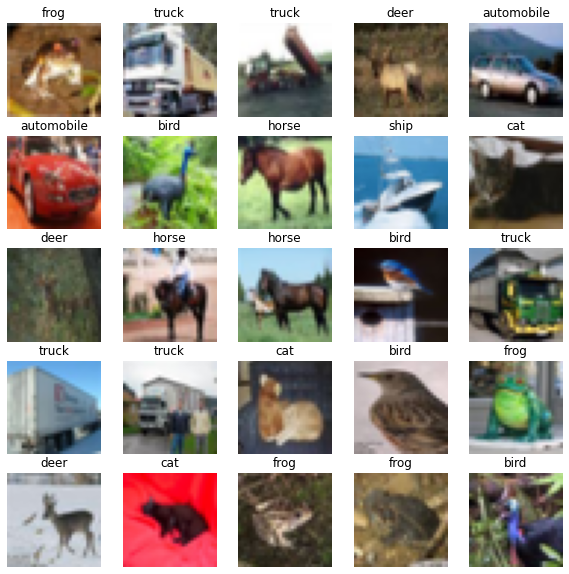

In [5]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [6]:
image.shape

torch.Size([3, 32, 32])

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(1563, 10000)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 12, 4, padding=1, stride=2),
            nn.AvgPool2d(3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(12, 24, 4, padding=1, stride=2),
            nn.AvgPool2d(3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(24, 48, 4, padding=1, stride=2),
            nn.AvgPool2d(3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.main(x)

In [9]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert encoder(noise).view(-1).shape[0] < 1*3*32*32

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
        )
    def forward(self, x):
        return torch.sigmoid(self.main(x))

In [11]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32)

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [12]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=10, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [13]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1076            2.22m
         2           1.9686            1.96m
         3           1.8577            1.72m
         4           1.7569            1.49m
         5           1.6680            1.22m
         6           1.5900           58.42s
         7           1.5201           43.65s
         8           1.4594           29.01s
         9           1.4048           14.50s
        10           1.3514            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3278

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [15]:
encoder.to(device)
decoder.to(device);

In [16]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [17]:
criterion = nn.MSELoss()

def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        optim.zero_grad()
        image = image.to(device)
        out = decoder(encoder(image))
        loss = criterion(out, image)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [18]:
temp_dataloader = DataLoader(Subset(train_dataset, [0]), batch_size=1)
loss = train(temp_dataloader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1 [00:00<?, ?it/s]

0.66603022813797

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [19]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        image = image.to(device)
        with torch.no_grad():
            out = decoder(encoder(image))
            loss = criterion(out, image)
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [20]:
temp_dataloader = DataLoader(Subset(train_dataset, [0]), batch_size=1)
loss = eval(temp_dataloader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1 [00:00<?, ?it/s]

0.6649571061134338

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [21]:
def full_train(device, train_loader, val_loader):
    !pip install gdown==4.2.0
    import gdown
    url = 'https://drive.google.com/file/d/1Uu0SlEHG9uOhm-8c-VPlBS1aNn0DZC5-/view?usp=sharing'
    gdown.download(url, 'encoder.weights', fuzzy=True)
    url = 'https://drive.google.com/file/d/1C89BlCbz04f4Oshu7ekAqjNzk8pXH7wS/view?usp=sharing'
    gdown.download(url, 'decoder.weights', fuzzy=True)
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    encoder.load_state_dict(torch.load('encoder.weights', map_location=device))
    decoder.load_state_dict(torch.load('decoder.weights', map_location=device))

    return encoder, decoder

#     params = list(encoder.parameters()) + list(decoder.parameters())
#     optim = torch.optim.AdamW(params)
#     train_loss = []
#     val_loss = []
#     n_epochs = 30
#     for e in trange(n_epochs):
#         e_train_loss = train(train_loader, optim, encoder, decoder, device)
#         train_loss.append(e_train_loss)
#         e_val_loss = eval(val_loader, encoder, decoder, device)
#         val_loss.append(e_val_loss)
#         print(f'Epoch: {e+1}/{n_epochs}')
#         print(f'Train MSE loss: {e_train_loss:.4f}')
#         print(f'Validation MSE loss: {e_val_loss:.4f}')
#     plt.plot(train_loss, label='train')
#     plt.plot(val_loss, label='val')
#     plt.legend()
#     plt.title('MSE Loss')
#     plt.show()
#     return encoder, decoder

In [22]:
encoder, decoder = full_train(device, train_loader, val_loader)

You should consider upgrading via the '/home/polli/anaconda3/bin/python -m pip install --upgrade pip' command.


Downloading...
From: https://drive.google.com/uc?id=1Uu0SlEHG9uOhm-8c-VPlBS1aNn0DZC5-
To: /home/polli/Downloads/encoder.weights
100%|██████████| 96.9k/96.9k [00:00<00:00, 3.25MB/s]
Downloading...
From: https://drive.google.com/uc?id=1C89BlCbz04f4Oshu7ekAqjNzk8pXH7wS
To: /home/polli/Downloads/decoder.weights
100%|██████████| 96.6k/96.6k [00:00<00:00, 1.98MB/s]


In [23]:
score = classification_score(encoder, train_dataset, val_dataset, device)
assert score > 0.34

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0842            2.15m
         2           1.9327            1.89m
         3           1.8052            1.65m
         4           1.6961            1.42m
         5           1.6013            1.18m
         6           1.5223           56.76s
         7           1.4476           42.51s
         8           1.3813           28.27s
         9           1.3219           14.15s
        10           1.2676            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

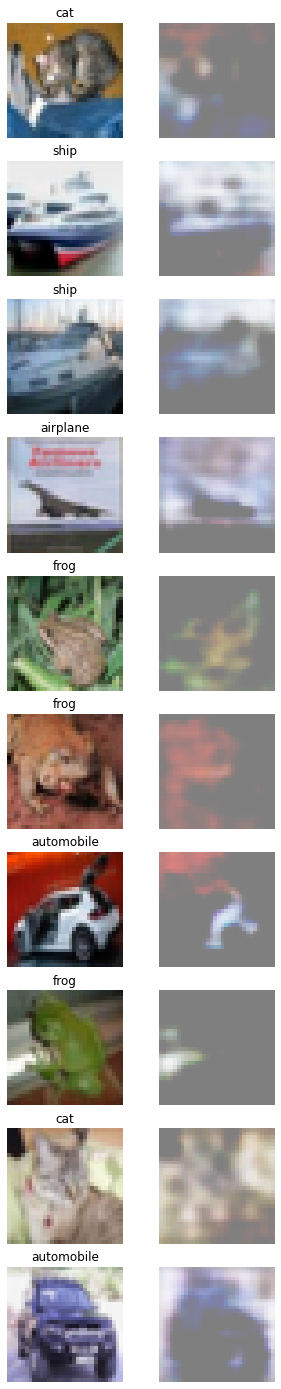

In [24]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [25]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    for image, label in dataloader:
        out = encoder(image.to(device)).detach().reshape(-1)
        representations[label.item()].append(out)
    return representations

In [26]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [58]:
def calculate_fid(repr1, repr2):
    mu1 = repr1.mean(0)
    cov1 = np.cov(repr1, rowvar=False)
    mu2 = repr2.mean(0)
    cov2 = np.cov(repr2, rowvar=False)
    
    w, v = np.linalg.eig(cov1 @ cov2)
    
    return np.linalg.norm(mu1 - mu2)**2 + np.trace(cov1+cov2 - 2.*(w**0.5) * v @ v.T).real

In [60]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

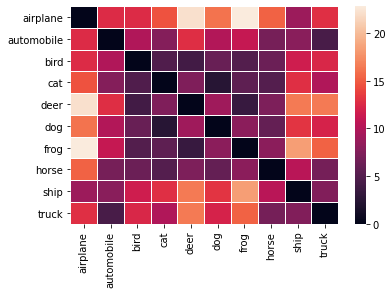

In [61]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.show()

In [62]:
heatmap[3, 5]

2.3569368315707466

## Задание 3 (3 балла)

Выберите ваш любимый датасет с кошками и собаками и посчитайте FID между двумя классами на новых данных, используя репрезентацию с уже обученного AE

хинт: если любимого датасета с кошками и собаками нет, можно вырезать эти классы из имажнета

хинт: если вам оооочень не нравятся кошки и собаки, то можете выбрать другие два противоположных класса

I downloaded dataset from Microsoft site. Also i deleted a couple of images, because there were some problems

In [33]:
pet_transforms = transforms.Compose([
                    transforms.Resize((32, 32)),
                    transforms.PILToTensor(),
                    transforms.ConvertImageDtype(torch.float),
                    lambda x: (x * 2) - 1
                ])   

In [34]:
pets_dataset = datasets.ImageFolder('PetImages', transform=pet_transforms)
pets_loader = DataLoader(pets_dataset, batch_size=1, shuffle=False)

pets_representations = get_representations(pets_loader, encoder, device)

/home/polli/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [40]:
print(len(pets_representations[0]), len(pets_representations[1]))
len_data = min(len(pets_representations[0]), len(pets_representations[1]))

12499 12497


In [35]:
calculate_fid(
    torch.stack(pets_representations[0][:1000], dim=0).cpu().numpy(),
    torch.stack(pets_representations[1][:1000], dim=0).cpu().numpy()
)

70.47149559003557

On this dataset on the same number of images FID is slightly less(70), then on CIFAR(75)

## Задание 4 (1 балл)

Вы отлично поработали и, скорее всего, в процессе выполнения этих задач у вас появились идеи о том, как еще можно решать подобные проблемы. 

Здесь вы можете описать способы которые вам хотелось бы попробовать если бы у вас было больше времени, или показать статьи которые вы читали, которые решают такие задачи.

Дополнительно, необходимо приложить сюда какой-нибудь смешной мем про генеративные модели за последние два года. Если мем будет не смешным, то баллы придется снять.

A recent model for constructing embeddings is a convolutional net called EfficientNet. It provides a class of automatically generated models with a tradeoff between the number of parameters (few parameters means fast inference and training) and accuracy. 
https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html